# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


The goals / steps of this project are the following:
*	Load the data set (see below for links to the project data set)
*	Explore, summarize and visualize the data set
*	Design, train and test a model architecture
*	Use the model to make predictions on new images
*	Analyze the softmax probabilities of the new images
*	Summarize the results with a written report



## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Use python, pandas or numpy methods rather than hard coding the results
import pandas as pd

# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_validation = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
labels_data = pd.read_csv("signnames.csv") 
n_classes = len(labels_data)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 


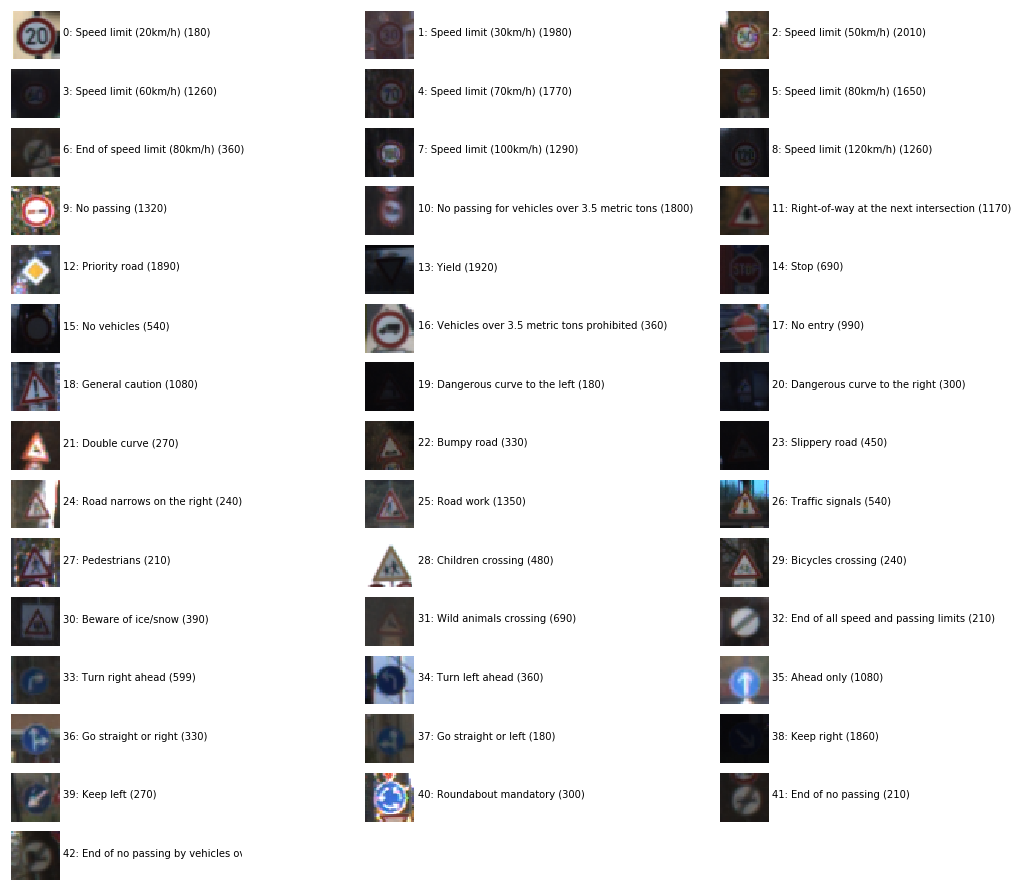

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Nr = 3
Nc = len(labels_data) // Nr + 1

fig, axs = plt.subplots(Nc, Nr, figsize=(18, 16), frameon=False)
i = 0

for row in axs:
    for item in row:
        item.get_xaxis().set_visible(False)
        item.get_yaxis().set_visible(False)
        item.spines['top'].set_visible(False)
        item.spines['right'].set_visible(False)
        item.spines['bottom'].set_visible(False)
        item.spines['left'].set_visible(False)

signs_count = np.zeros(n_classes, np.uint32);
for sign_index in labels_data['ClassId']:
    #print(labels_data['SignName'][i])
    #print("Number in train set: ", np.count_nonzero(y_train == sign_index))
    index_of_first_sign = np.argwhere(y_train == sign_index)[0];
    image = X_train[index_of_first_sign][0]
    gridx = i // Nr
    gridy = i % Nr
    axs[gridx, gridy].imshow(image)
    signs_count[sign_index] =np.count_nonzero(y_train == sign_index)
    axs[gridx, gridy].text(image.shape[1] + 2, image.shape[1] // 2,  str(sign_index) + ": " + labels_data['SignName'][i] \
                           + ' (' + str(signs_count[sign_index]) + ')')
    i = i + 1
    
plt.show()

## The distribution in training dataset

<Container object of 43 artists>

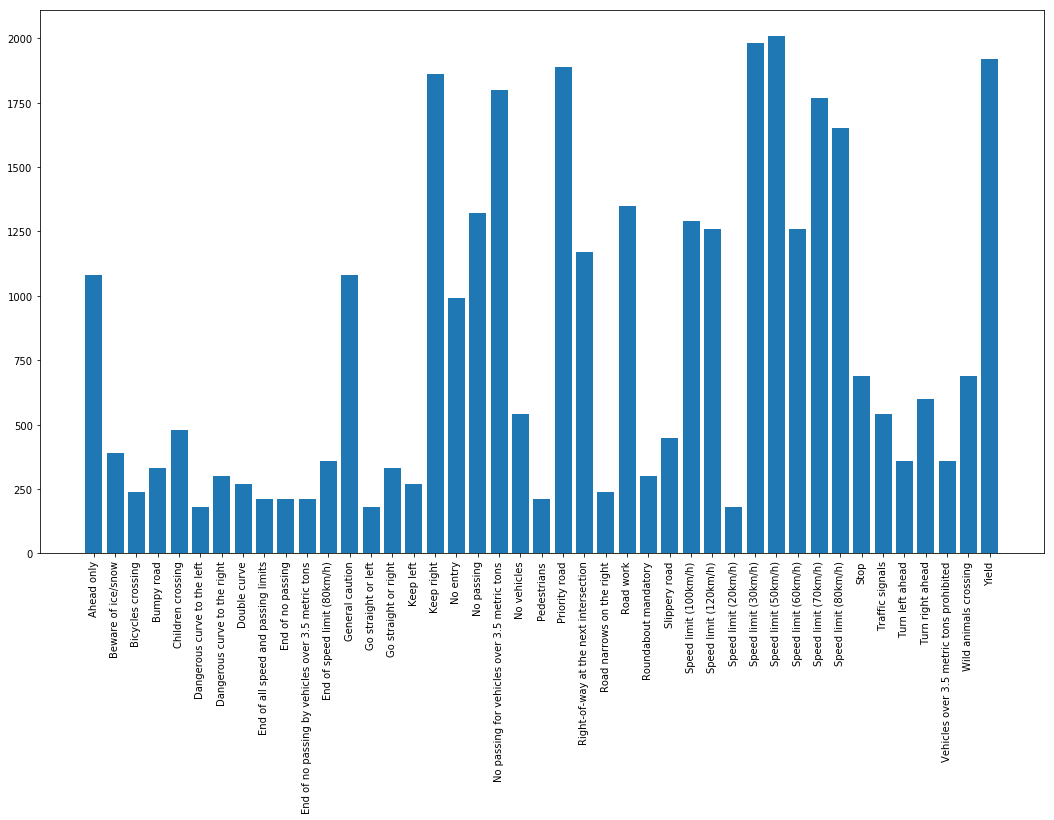

In [4]:
plt.figure(figsize=(18,10))
plt.xticks(rotation=90)
plt.bar(labels_data['SignName'], signs_count)

----

## Step 2: Design and Test a Model Architecture

The LeNet-5 implementation is used as architecture of the deep learning model for german traffic signs recognition (for the dataset presented above) 


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. 
Another option is to use normalized gray images to reduce model сomplexity
The additional option is to add fake images for the labels with low accurancy in training data

Normalized images shape: (32, 32)
Check that data is normalized correctly:
Max point value 1.0
Min point value -1.0
Origina, normalized and fake image: 


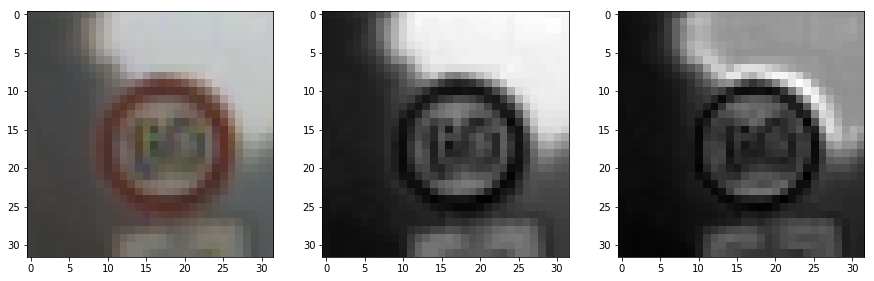

Adding fake images for the class 0 len 180
Adding fake images for the class 6 len 360
Adding fake images for the class 16 len 360
Adding fake images for the class 19 len 180
Adding fake images for the class 20 len 300
Adding fake images for the class 21 len 270
Adding fake images for the class 22 len 330
Adding fake images for the class 23 len 450
Adding fake images for the class 24 len 240
Adding fake images for the class 27 len 210
Adding fake images for the class 28 len 480
Adding fake images for the class 29 len 240
Adding fake images for the class 30 len 390
Adding fake images for the class 32 len 210
Adding fake images for the class 34 len 360
Adding fake images for the class 36 len 330
Adding fake images for the class 37 len 180
Adding fake images for the class 39 len 270
Adding fake images for the class 40 len 300
Adding fake images for the class 41 len 210
Adding fake images for the class 42 len 210
New training set size: 40859


In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import cv2

def get_gray(image):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray

def image_normalize(image):
    pix_mean = (np.min(image) + np.max(image)) / 2;
    dist = (np.max(image) - np.min(image)) / 2
    if (dist == 0):
        return image
    return (image - pix_mean) / dist

def get_sobel(image):
    gray = get_gray(image)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(get_gray(image), cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx) + np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.float64(abs_sobelx/np.max(abs_sobelx))
    scaled_sobel = gray*(1 + scaled_sobel)
    return scaled_sobel
    

def convert_to_one_channel_image_and_normalize(X_features):
    n_features = len(X_features)
    X_norm = np.zeros([n_features, image_shape[0], image_shape[1]])
    for i in range(n_features):
        image =  X_features[i]
        X_norm[i] = get_gray(image)
        X_norm[i] = image_normalize(X_norm[i])
        if (np.count_nonzero(X_norm[i] > 1)):
            print("incorrect norm")
    return X_norm;

X_train_norm = convert_to_one_channel_image_and_normalize(X_train)
X_valid_norm = convert_to_one_channel_image_and_normalize(X_valid)
X_test_norm = convert_to_one_channel_image_and_normalize(X_test)

print("Normalized images shape: " + str(X_train_norm[0].shape))

fig, axs = plt.subplots(1, 3, figsize=(15, 15), frameon=True)
index = random.randint(0, n_train)
axs[0].imshow(X_train[index])
axs[1].imshow(X_train_norm[index], cmap = 'gray')
random_fake_img = image_normalize(get_sobel(X_train[index]))
axs[2].imshow(random_fake_img, cmap = 'gray')

print ("Check that data is normalized correctly:")
print("Max point value " + str(np.max(X_train_norm)))
print("Min point value " + str(np.min(X_train_norm)))

print("Origina, normalized and fake image: ")
plt.show()

y_train_norm  = y_train

for sign_index in range(n_classes):
    fake_images = []
    if signs_count[sign_index] < 500:
        for i in range(n_train):
            if y_train[i] == sign_index:
                fake_images.append(image_normalize(get_sobel(X_train[i])))
    if len(fake_images) > 0:
        print("Adding fake images for the class " + str(sign_index) + " len " + str(len(fake_images)))
        fake_images_array = np.array(fake_images)
        X_train_norm = np.concatenate((X_train_norm, np.array(fake_images)))
        y_train_norm = np.append(y_train_norm, np.full(len(fake_images), sign_index))
      
n_norm_train = len(X_train_norm)
print("New training set size: " + str(n_norm_train))
                                    

### Model Architecture

The classic 4 levels LeNet architecture is used
Such manipulations are presented:
* convolution
* max pooling
* dropout
* fully connected

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1, pad ='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding = pad)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.05
    
    x = tf.reshape(x, shape=[-1, image_shape[0], image_shape[1], 1])
    
    weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 8), mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 8, 12), mean = mu, stddev = sigma)),
    'wf1': tf.Variable(tf.truncated_normal(shape=(300,120), mean = mu, stddev = sigma)),
    'wf2': tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma)),
    'wout': tf.Variable(tf.truncated_normal(shape=(84,n_classes), mean = mu, stddev = sigma))}

    biases = {
    'bc1': tf.Variable(tf.zeros([8])),
    'bc2': tf.Variable(tf.zeros([12])),
    'bf1': tf.Variable(tf.zeros([120])),
    'bf2': tf.Variable(tf.zeros([84])),
    'bout': tf.Variable(tf.zeros([n_classes]))}
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x8.
    l1 = conv2d(x, weights['wc1'], biases['bc1'], 1 , 'VALID')
    
    # Pooling. Input = 28x28x6. Output = 14x14x8.
    l1 = maxpool2d(l1, 2)
  
    # Layer 2: Convolutional. Output = 10x10x12.
    l2 = conv2d(l1, weights['wc2'], biases['bc2'], 1 , 'VALID')
    # Pooling. Input = 10x10x16. Output = 5x5x12.
    l2 = maxpool2d(l2, 2)

    # Flatten. Input = 5x5x16. Output = 300.
    
    l2d = tf.contrib.layers.flatten(l2)
    # Layer 3: Fully Connected. Input = 300. Output = 120.
    l3 = tf.add(tf.matmul(l2d, weights['wf1']), biases['bf1'])

    # Activation.
    l3 = tf.nn.relu(l3)
    l3 = tf.nn.dropout(l3, keep_prob)
    # Layer 4: Fully Connected. Input = 120. Output = 84.   
    l4 = tf.add(tf.matmul(l3, weights['wf2']), biases['bf2'])
    # Activation.
    l4 = tf.nn.relu(l4)
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    
    logits = tf.add(tf.matmul(l4, weights['wout']), biases['bout'])
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

TF model declarations:

In [7]:
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1]))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

one_hot_y = tf.one_hot(y, n_classes)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


rate = 0.005
EPOCHS = 15
BATCH_SIZE = 256

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

Training the model

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train_norm, y_train_norm = shuffle(X_train_norm, y_train_norm)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_norm[offset:end], y_train_norm[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
            
        testing_accuracy = evaluate(X_train_norm, y_train_norm)
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(testing_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...
EPOCH 1 ...
Training Accuracy = 0.801
Validation Accuracy = 0.770
EPOCH 2 ...
Training Accuracy = 0.933
Validation Accuracy = 0.881
EPOCH 3 ...
Training Accuracy = 0.963
Validation Accuracy = 0.927
EPOCH 4 ...
Training Accuracy = 0.971
Validation Accuracy = 0.924
EPOCH 5 ...
Training Accuracy = 0.980
Validation Accuracy = 0.941
EPOCH 6 ...
Training Accuracy = 0.985
Validation Accuracy = 0.944
EPOCH 7 ...
Training Accuracy = 0.988
Validation Accuracy = 0.940
EPOCH 8 ...
Training Accuracy = 0.990
Validation Accuracy = 0.954
EPOCH 9 ...
Training Accuracy = 0.991
Validation Accuracy = 0.951
EPOCH 10 ...
Training Accuracy = 0.992
Validation Accuracy = 0.959
EPOCH 11 ...
Training Accuracy = 0.993
Validation Accuracy = 0.954
EPOCH 12 ...
Training Accuracy = 0.991
Validation Accuracy = 0.951
EPOCH 13 ...
Training Accuracy = 0.994
Validation Accuracy = 0.953
EPOCH 14 ...
Training Accuracy = 0.991
Validation Accuracy = 0.950
EPOCH 15 ...
Training Accuracy = 0.990
Validation Accuracy 

Test model on the test images:

In [9]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')

    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.914


---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, 10 new images of German traffic signs  were downloaded from the web.  The  model is used to predict the traffic sign type.


### Load and Output the Images. Predict the image signs

Images from web: 


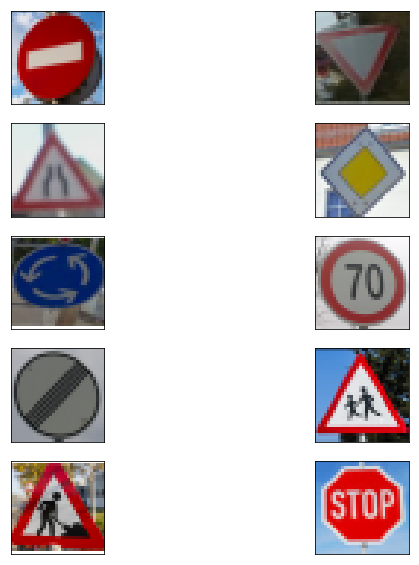

In [10]:
import matplotlib.image as mpimg
import os
input_path = "test_images";
fig, axs = plt.subplots(5, 2, figsize=(10, 10), frameon=False)
num_of_images = len(os.listdir(input_path)) - 1
i = 0;
for col in range(5):
    for row in range(2):
        filename = "sign_" + str(i+1) + ".png";
        image = mpimg.imread(  os.path.join( input_path, filename ))
        axs[col][row].imshow(image)
        axs[col][row].get_xaxis().set_visible(False)
        axs[col][row].get_yaxis().set_visible(False)
        i = i + 1
print("Images from web: ")
plt.show()

INFO:tensorflow:Restoring parameters from ./lenet


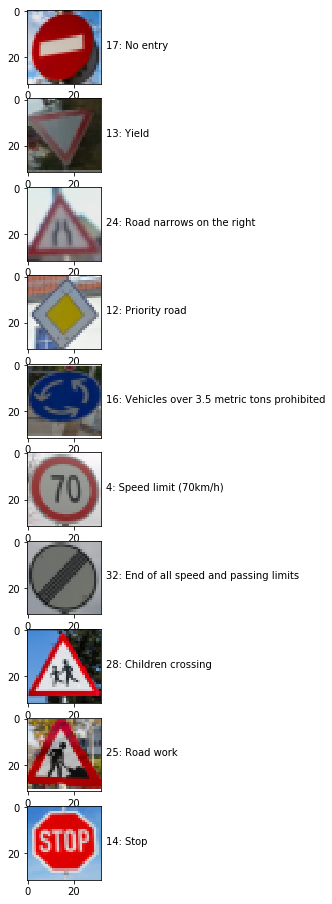

In [11]:
### Load the images and plot them here.
import matplotlib.image as mpimg
import os
input_path = "test_images";

fig, axs = plt.subplots(10, 1, figsize=(18, 16), frameon=False)
i = 0;
predicted_indices = [];

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_of_images = len(os.listdir(input_path)) - 1
    for i in range(num_of_images):
        filename = "sign_" + str(i+1) + ".png";
        image = mpimg.imread(  os.path.join( input_path, filename ))
        norm_image = convert_to_one_channel_image_and_normalize([image]);
        axs[i].imshow(image, cmap = 'gray')
        predict = sess.run(logits, feed_dict={x: norm_image, keep_prob: 1.0})
        y = np.argmax(predict, axis=1)[0]
        predicted_indices.extend([y])
        axs[i].text(image.shape[1] + 2, image.shape[1] // 2,  str(y) + ": " + labels_data['SignName'][y])
        i = i + 1
plt.show()

    
    

### Analyze Performance

In [12]:
### Calculate the accuracy for these 5 new images. 
real_indices = [17, 13, 24, 12, 40, 4, 32, 28, 25, 14]
diff_count = np.count_nonzero(np.subtract(real_indices , predicted_indices))
print(predicted_indices)
print("Number of incorrectly predicted images: " + str(diff_count))
print("Accuracy: " + str(100 - diff_count / len(real_indices) * 100) + "%")

[17, 13, 24, 12, 16, 4, 32, 28, 25, 14]
Number of incorrectly predicted images: 1
Accuracy: 90.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, the model's softmax probabilities are displyed to show the **certainty** of the model's predictions 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. 


INFO:tensorflow:Restoring parameters from ./lenet


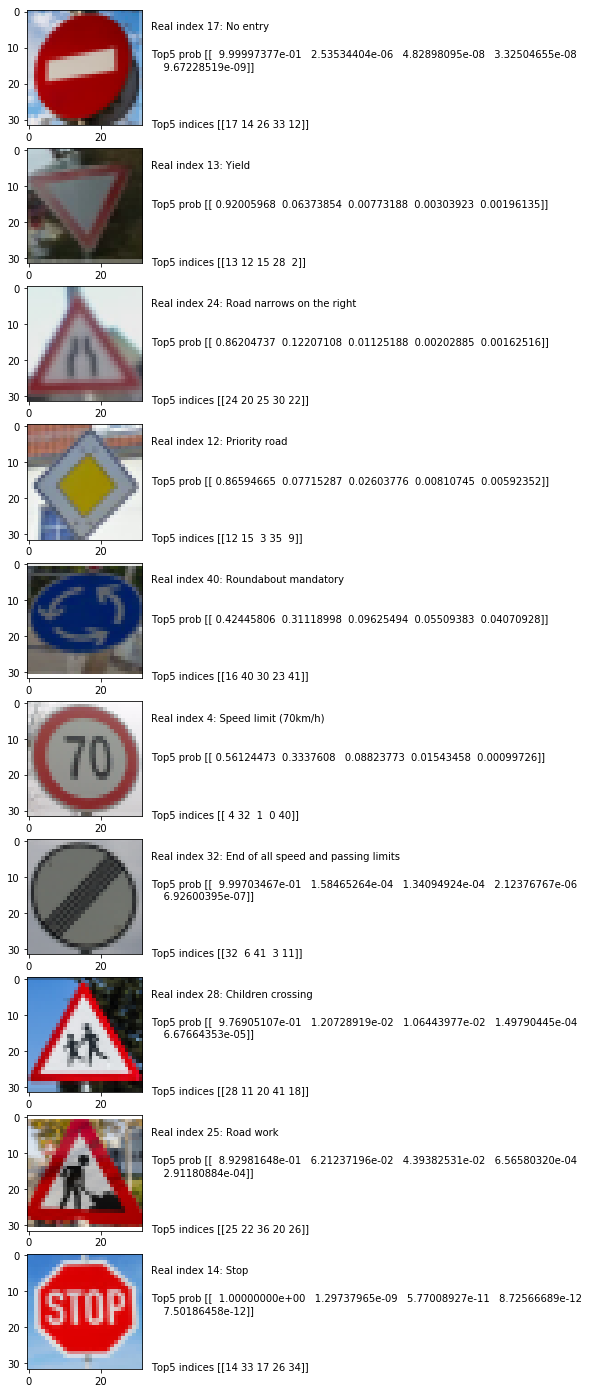

In [13]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
soft_max = tf.nn.softmax(logits)
top5 = tf.nn.top_k(soft_max, 5)

fig, axs = plt.subplots(10, 1, figsize=(15, 25), frameon=False)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_of_images = len(os.listdir(input_path)) - 1
    top5_predictions = []
    for i in range(num_of_images):
        filename = "sign_" + str(i+1) + ".png";
        image = mpimg.imread(  os.path.join( input_path, filename ))
        norm_image = convert_to_one_channel_image_and_normalize([image]);
        axs[i].imshow(image, cmap = 'gray')
        top5_predictions.append(sess.run(top5, feed_dict={x: norm_image, keep_prob: 1}))
        axs[i].text(image.shape[1] + 2, 5,  "Real index " + str(real_indices[i]) + ": " + labels_data['SignName'][real_indices[i]])
        axs[i].text(image.shape[1] + 2, image.shape[0] // 2,  "Top5 prob " + str(top5_predictions[i].values))
        axs[i].text(image.shape[1] + 2, image.shape[0],  "Top5 indices " + str(top5_predictions[i].indices))
        i = i + 1
plt.show()
    


The probabilities for each sign

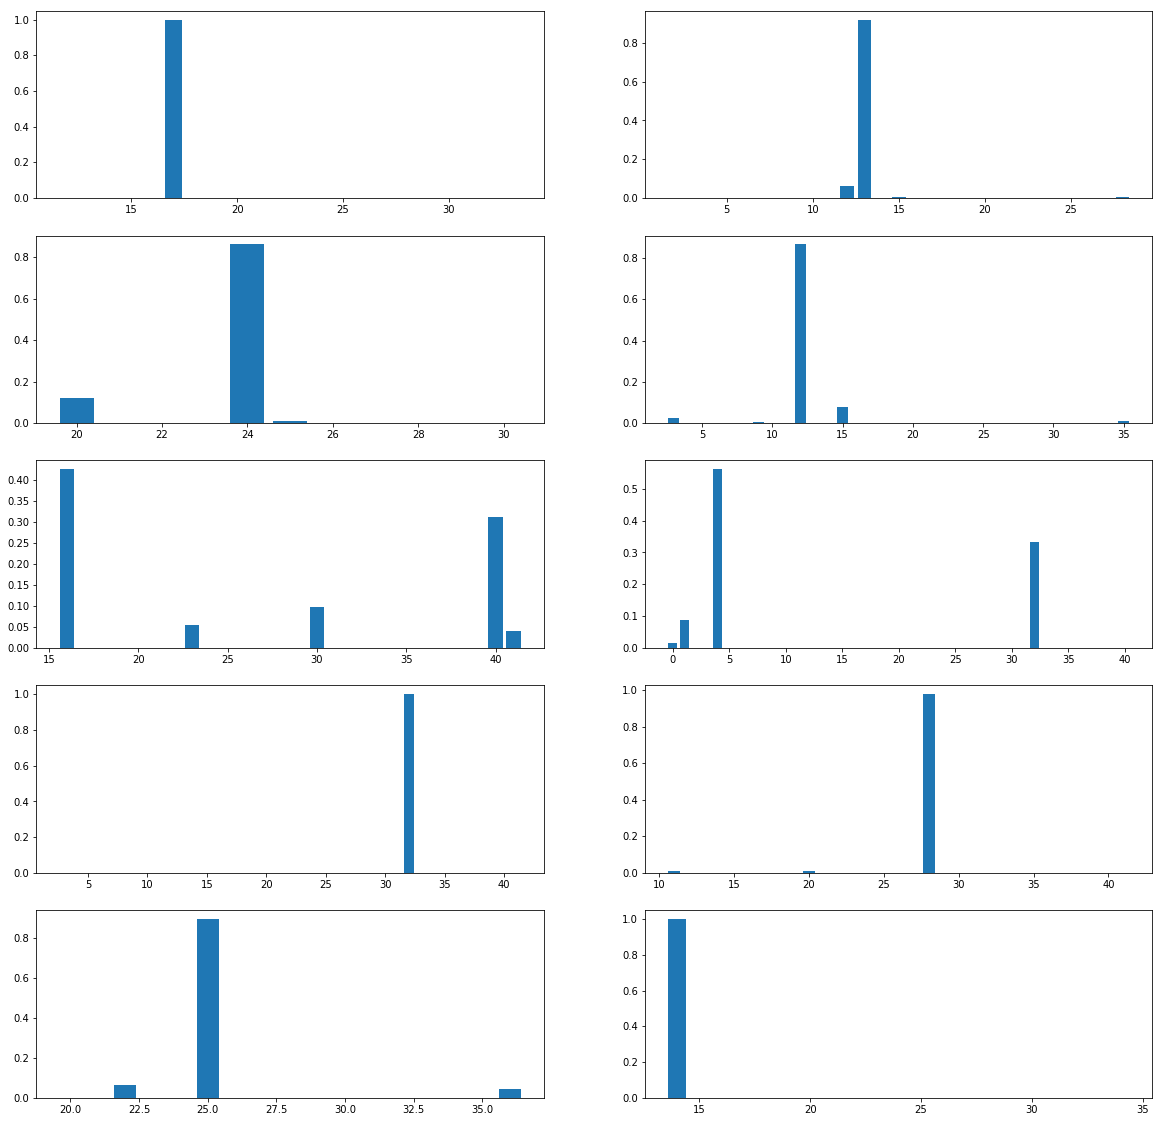

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), frameon=False)
for ygrid in range(5):
    for  xgrid in range(2):
        i = ygrid*2 + xgrid
        axs[ygrid][xgrid].bar(top5_predictions[i].indices.squeeze() , top5_predictions[i].values.squeeze() )        
plt.show()

### Project Writeup

Project writeup can be found in the same folder with name **Traffic_Sign_Recognition_writeup.pdf**